<p style="text-align: center; font-size: 30px" > Midterm Assignment </p>

<p style="text-align: right; font-size: 20px"> BRI519 (Fall/2025) </p>

<p style="text-align: right; font-size: 15px"> Provided on November 6 (Thursday) and due on November 17 (Monday) </p>

<br>

Your name: 박영준
<br>

Your ID: 2024022004




## General Notes 

(i) Please **do not discuss** this assignment with your friends. Instead, develop your own ideas independently, using AI tools if necessary. If you use any AI tools, **explicitly state which tools were used in the corresponding notebook cell**. 

(ii) When solving each (sub-)problem, feel free to use **multiple Python and/or Markdown cells** as needed. 

(iii) Please write your responses in **English**. 

<br>

Please submit your jupyter-notebook file, **"bri519_2025fall_midterm_yourname_id.ipynb"**, to the TA (neti2207@korea.ac.kr) and instructor (jonghwan_lee@korea.ac.kr) <br>

If you have any issues, please reach out to the TA via an email.    <br>


## Question: mouseLFPAnalysis
[**Goal**] Write low-level Python code to perform analyses of LFP data (mouseLFP.mat) recorded from the mouse auditory cortex in response to tone stimuli.

<br>
Please complete the following tasks:

(a) Run the MATLAB script **mouseLFPAnalysisProgram.m**, familiarize yourself with the overall analysis steps and the dataset (**mouseLFP.mat**), and then perform the corresponding analyses.

(b) Write Python code to analyze the LFP data following the steps outlined below.


(1) **Initial Step**: Start from a blank workspace and define the necessary constant variables.


In [1]:
import numpy as np

In [2]:
cutoffFrequency = 1e3
binWidth = 5
maxFreq = 200
numTrials = 200
numSessions = 4
fs = 1e4
nyquist = fs / 2
stimOnset = 1000 # 100ms
stimOffset = 1500 # 150ms

wind = np.hanning(256)
overl = 255
nfft = np.arange(0, maxFreq + binWidth, binWidth) 

(2) **Loader**: Load the dataset, "**mouseLFP.mat**" and assign the key data and parameters to appropriate variables


In [3]:
import scipy.io as io

In [4]:
DATA = io.loadmat("mouseLFP.mat")['DATA']

numSessions = DATA.shape[0]        
numTrials = DATA[0, 0].shape[0]    
dataSamples = DATA[0, 0].shape[1] 

In [5]:
lfp_raw = []; tone_vals = []    

for i in range(numSessions):
    lfp_raw.append(DATA[i, 0])      
    tone_vals.append(DATA[i, 4][:, 0])    

lfp_raw = np.array(lfp_raw); tone_vals = np.array(tone_vals)

(3) **Outlier Sample Rejection**

* The dataset was acquired from four sessions (200 trials per session), each containing either low or high auditory tone stimuli and the measured LFP signals.

* The stimulus onset and offset were 100 ms and 150 ms.

* Upon inspecting the raw data, you may notice that some trials show noisy or outlier measurements. 

* Develop a method or set of criteria to identify and exclude outlier trials from the raw data, and show the results.

* Clearly explain your reasoning for the chosen outlier detection criteria.

* Report the number of trials available before and after outlier rejection for each session.

* Report the number of trials available across all four sessions for each tone condition after outlier exclusion.

In [6]:
whole_lfp_raw = lfp_raw.reshape(-1, 3000); whole_lfp_baseline = whole_lfp_raw[:, :stimOnset]

# rms 
baseline_rms = np.sqrt(np.mean(whole_lfp_baseline**2, axis=1)); rms_mean = np.mean(baseline_rms); rms_std = np.std(baseline_rms)

# p2p
baseline_p2p = whole_lfp_baseline.max(axis=1) - whole_lfp_baseline.min(axis=1); p2p_mean = np.mean(baseline_p2p); p2p_std = np.std(baseline_p2p)

* I used ChatGPT to find outlier detection algorithm

In [7]:
def is_outlier_rms(trial, baseline_end):
    baseline = trial[:baseline_end]
    rms = np.sqrt(np.mean(baseline**2))
    return rms > rms_mean + 3 * rms_std

def is_outlier_p2p(trial, baseline_end):
    baseline = trial[:baseline_end]
    p2p = baseline.max() - baseline.min()
    return p2p > p2p_mean + 3 * p2p_std

* Since the neural response after stimulation can vary from trial to trial, outliers were determined based only on the baseline signal before stimulation, which is a predictable stable interval.
* Since RMS well reflects the overall signal energy of the baseline period and the size of continuous noise, trials showing abnormally high RMS were considered as noise-containing signals and included in the removal criteria.
* Peak-to-peak amplitude(P2P) is useful for detecting trials with rapid peak fluctuations because it sensitively captures large instantaneous amplitude fluctuations or motion artifacts in the signal, and was used together as a criterion for removal.
* Since RMS and P2P are complementary metrics that capture different types of noise, if either criterion falls outside the normal range, the trial was classified as an outlier.
* The reason why the entire trial population was used as the ground truth is that most trials are likely to be normal signals, so a threshold based on the mean and standard deviation of the entire distribution provides a stable and objective standard.


In [8]:
sig_mask = np.zeros((numSessions, numTrials), dtype=bool)
for session_idx in range(numSessions):
    for trial_idx in range(numTrials):
        trial = lfp_raw[session_idx, trial_idx]
        if not is_outlier_rms(trial, stimOnset) and not is_outlier_p2p(trial, stimOnset):
            sig_mask[session_idx, trial_idx] = True

In [9]:
lfp_outlier_removed = []  

for i in range(numSessions):
    clean_session = lfp_raw[i][sig_mask[i]]   
    lfp_outlier_removed.append(clean_session)

- Report the number of trials available before and after outlier rejection for each session.

In [10]:
for i in range(numSessions):
    print("Session{} trials: 200 -> {}".format(i+1, lfp_outlier_removed[i].shape[0]))

Session1 trials: 200 -> 197
Session2 trials: 200 -> 191
Session3 trials: 200 -> 188
Session4 trials: 200 -> 198


* Report the number of trials available across all four sessions for each tone condition after outlier exclusion.

In [11]:
tone_outlier_removed = []  

for i in range(numSessions):
    clean_session = tone_vals[i][sig_mask[i]]   
    tone_outlier_removed.append(clean_session)

In [12]:
lfp_low_outlier_removed = []; lfp_high_outlier_removed = []
tone_low_vals = []; tone_high_vals = []

for i in range(numSessions):
    temp_lfp = lfp_outlier_removed[i]; temp_tone = tone_outlier_removed[i]
    temp = np.unique(temp_tone); low_tone = temp.min(); high_tone = temp.max()

    tone_low_vals.append(low_tone); tone_high_vals.append(high_tone)
    low_mask = temp_tone == low_tone; high_mask = temp_tone == high_tone

    lfp_low_outlier_removed.append(temp_lfp[low_mask])    
    lfp_high_outlier_removed.append(temp_lfp[high_mask])  

    print("Session {}: low_trials {}, high_trials {}".format(i+1, temp_lfp[low_mask].shape[0], temp_lfp[high_mask].shape[0]))

Session 1: low_trials 100, high_trials 97
Session 2: low_trials 99, high_trials 92
Session 3: low_trials 95, high_trials 93
Session 4: low_trials 98, high_trials 100


(4) **Filtering**

* Design a 10th-order Butterworth low-pass filter with a cutoff frequency of 1000 Hz using the `scipy.signal.butter` function.

* Apply the filter to each trial in each session using the `scipy.signal.filtfilt` function.

In [13]:
from scipy.signal import butter, filtfilt

In [14]:
lowPassData = np.zeros((numSessions, numTrials, dataSamples))
b, a = butter(10, 1000 / nyquist, btype='low')

In [15]:
lfp_low_filtered = []

for i in range(len(lfp_low_outlier_removed)):
    temp_ls = []
    for j in range(len(lfp_low_outlier_removed[i])):
        sig = lfp_low_outlier_removed[i][j]
        temp_ls.append(filtfilt(b, a, sig).tolist())
    lfp_low_filtered.append(temp_ls)

In [16]:
lfp_high_filtered = []

for i in range(len(lfp_high_outlier_removed)):
    temp_ls = []
    for j in range(len(lfp_high_outlier_removed[i])):
        sig = lfp_high_outlier_removed[i][j]
        temp_ls.append(filtfilt(b, a, sig).tolist())
    lfp_high_filtered.append(temp_ls)

(5) **Main Analysis**

(i) Propose two different ideas or methods to analyze the LFP signals in response to low and high tone stimuli, and describe each approach below.

(ii) Apply both methods to the LFP data for each session, present the results in both the time and frequency domains, and discuss your findings.

* I used ChatGPT to find method & visualization

(Idea/Method 1)

- ERP (Event-Related Potential) is an analysis technique that can extract only signals that consistently appear in response to a stimulus. It performs baseline correction for each trial using the pre-stimulus interval (baseline) to leave only pure stimulus-induced signals.
- For each session, I computed trial-averaged ERPs for low and high tones and compared the difference in responses between the two conditions in the time domain.
- By measuring the peak amplitude and latency of the post-stimulus interval in ERP, I evaluate how the two stimulus conditions differ in neural response size and time delay.
- The power spectrum is estimated using the Welch method for the calculated ERP signal, and the conditional response characteristics are compared in the frequency domain.

Code implementation below with results and discussion

In [17]:
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

In [18]:
def compute_erp(lfp_trials):
    lfp_trials = np.array(lfp_trials)
    
    baseline = lfp_trials[:, :stimOnset].mean(axis=1, keepdims=True)
    lfp_bc = lfp_trials - baseline
    erp = lfp_bc.mean(axis=0)

    n_samples = erp.shape[0]
    t_ms = np.arange(n_samples) / fs * 1000.0

    return erp, t_ms

In [19]:
erp_low_all = []; erp_high_all = []; t_ms = None

for i in range(numSessions):
    erp_low, t_ms = compute_erp(lfp_low_filtered[i])
    erp_high, t_ms = compute_erp(lfp_high_filtered[i])

    erp_low_all.append(erp_low)
    erp_high_all.append(erp_high)

erp_low_all = np.array(erp_low_all); erp_high_all = np.array(erp_high_all)

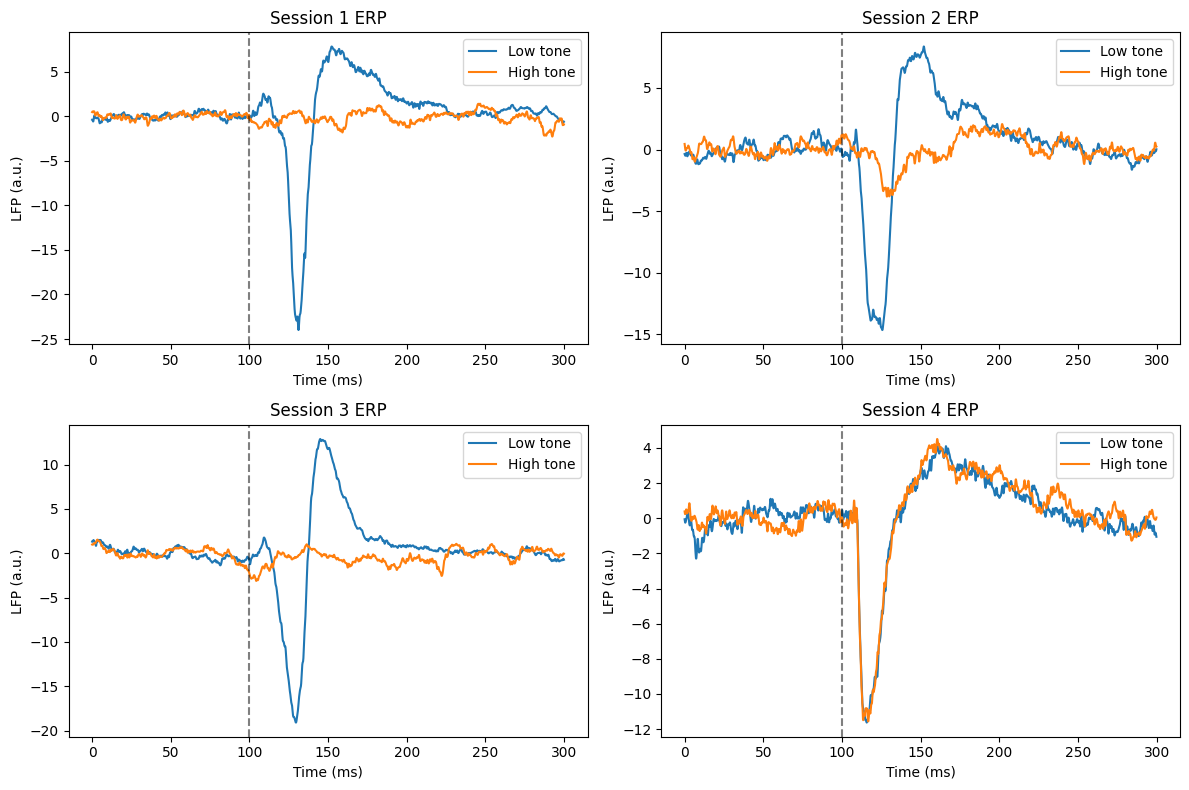

In [20]:
plt.figure(figsize=(12, 8))

for i in range(numSessions):
    plt.subplot(2, 2, i + 1)
    plt.plot(t_ms, erp_low_all[i],  label="Low tone")
    plt.plot(t_ms, erp_high_all[i], label="High tone")
    
    plt.axvline(stimOnset / fs * 1000.0, color='k', linestyle='--', alpha=0.5)
    
    plt.title(f"Session {i+1} ERP")
    plt.xlabel("Time (ms)")
    plt.ylabel("LFP (a.u.)")
    plt.legend()

plt.tight_layout()
plt.show()


In [21]:
win_start_ms, win_end_ms = (100, 250)

for i in range(numSessions):
    print(f"\n=== Session {i+1} ===")

    for cond_name, erp in zip(["Low", "High"], [erp_low_all[i], erp_high_all[i]]):
        start_idx = int(win_start_ms * 10); end_idx = int(win_end_ms * 10)
        segment = erp[start_idx:end_idx]
        
        local_idx = np.argmin(segment)
        peak_amp = segment[local_idx]
    
        peak_idx = start_idx + local_idx
        latency_ms = (peak_idx - stimOnset) / fs * 1000.0

        print(f"{cond_name} tone -> peak_amp = {peak_amp:.4f}, latency = {latency_ms:.1f} ms")


=== Session 1 ===
Low tone -> peak_amp = -23.9892, latency = 31.2 ms
High tone -> peak_amp = -1.8307, latency = 59.1 ms

=== Session 2 ===
Low tone -> peak_amp = -14.6641, latency = 25.7 ms
High tone -> peak_amp = -3.8215, latency = 28.6 ms

=== Session 3 ===
Low tone -> peak_amp = -19.0839, latency = 29.6 ms
High tone -> peak_amp = -3.1154, latency = 4.3 ms

=== Session 4 ===
Low tone -> peak_amp = -11.6275, latency = 15.7 ms
High tone -> peak_amp = -11.5654, latency = 16.7 ms


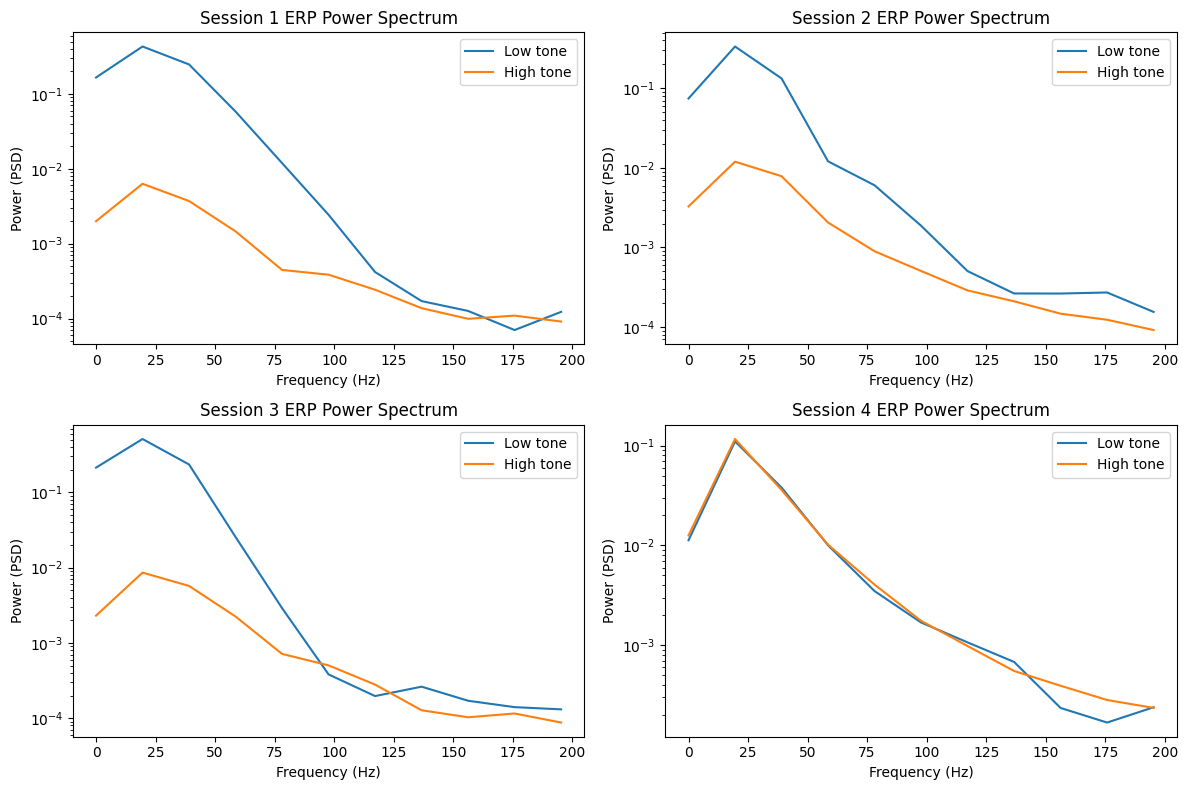

In [22]:
max_freq = 200  

plt.figure(figsize=(12, 8))

for i in range(numSessions):
    erp_l = erp_low_all[i]
    erp_h = erp_high_all[i]
    
    freqs_l, psd_l = welch(erp_l, fs=fs, nperseg=512)
    freqs_h, psd_h = welch(erp_h, fs=fs, nperseg=512)
    
    mask_l = freqs_l <= max_freq
    mask_h = freqs_h <= max_freq
    
    plt.subplot(2, 2, i + 1)
    plt.semilogy(freqs_l[mask_l], psd_l[mask_l], label="Low tone")
    plt.semilogy(freqs_h[mask_h], psd_h[mask_h], label="High tone")
    
    plt.title(f"Session {i+1} ERP Power Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (PSD)")
    plt.legend()

plt.tight_layout()
plt.show()


* Idea1 findings
    * In the time domain, low tones generally induced stronger negative potential changes than high tones. The response decreased with increasing frequency. However, in the case of Ses4, the low tones themselves were high-frequency, so no significant difference was observed. Furthermore, low frequencies had a latency of 30 ms in the time domain.
    * In the frequency domain, ERP power for low tones was found to be greater overall. Furthermore, the highest values ​​were observed in the 5-30 Hz range, indicating the theta-beta region.

(Idea/Method 2)

- Time-Frequency analysis is a method that can simultaneously observe how power changes occur in a specific frequency band after stimulation, and can detect instantaneous and frequency-specific brain responses that cannot be observed with ERP.
- For each session, I calculated the trial-by-trial spectrograms for low/high tones and averaged them to compare the frequency-specific power changes induced by the stimulus over time.
- By calculating the temporal change in power in specific frequency bands such as theta, beta, and gamma, we evaluated in which frequency band the two stimulus conditions showed a relatively strong response.
- In addition, I analyzed the difference between the two stimulus conditions in the frequency domain as well as the time domain through the average spectrogram and the band-power change pattern.

Code implementation below with results and discussion

In [23]:
def compute_mean_spectrogram(lfp_trials, fs, nperseg=256, noverlap=200, max_freq=100):
    lfp_trials = np.array(lfp_trials); n_trials, _ = lfp_trials.shape

    f, t, S = spectrogram(lfp_trials[0], fs=fs, nperseg=nperseg, noverlap=noverlap)
    S_power = np.abs(S) ** 2
    S_sum = S_power.copy()

    for i in range(1, n_trials):
        _, _, S_i = spectrogram(lfp_trials[i], fs=fs, nperseg=nperseg, noverlap=noverlap)
        S_sum += np.abs(S_i) ** 2
    S_avg = S_sum / n_trials

    freq_mask = f <= max_freq
    f_sel = f[freq_mask]
    S_avg = S_avg[freq_mask, :]

    return f_sel, t, S_avg

In [24]:
tf_low  = []; tf_high = []

for i in range(numSessions):
    f_l, t_l, S_l = compute_mean_spectrogram(lfp_low_filtered[i], fs)
    f_h, t_h, S_h = compute_mean_spectrogram(lfp_high_filtered[i], fs)

    tf_low.append((f_l, t_l, S_l))
    tf_high.append((f_h, t_h, S_h))

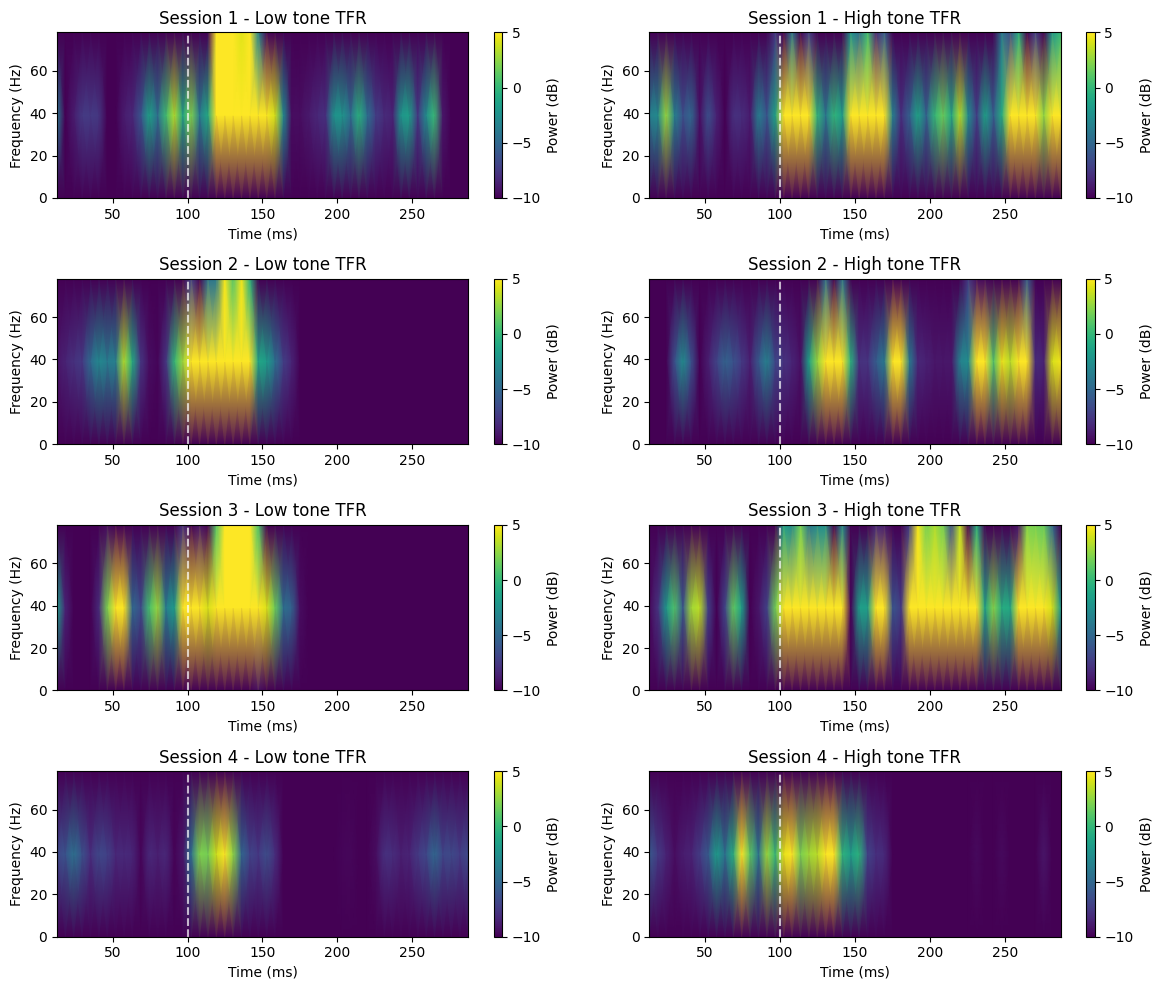

In [25]:
vmin, vmax = -10, 5
plt.figure(figsize=(12, 10))

for i in range(numSessions):
    f_l, t_l, S_l = tf_low[i]
    f_h, t_h, S_h = tf_high[i]

    S_l_db = 10 * np.log10(S_l + 1e-12)
    S_h_db = 10 * np.log10(S_h + 1e-12)

    # ---- Low tone ----
    plt.subplot(numSessions, 2, 2 * i + 1)
    plt.pcolormesh(t_l * 1000.0, f_l, S_l_db, shading='gouraud', vmin=vmin, vmax=vmax)
    plt.axvline(stimOnset / fs * 1000.0, color='w', linestyle='--', alpha=0.7)
    plt.title(f"Session {i+1} - Low tone TFR")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")

    # ---- High tone ----
    plt.subplot(numSessions, 2, 2 * i + 2)
    plt.pcolormesh(t_h * 1000.0, f_h, S_h_db, shading='gouraud', vmin=vmin, vmax=vmax)
    plt.axvline(stimOnset / fs * 1000.0, color='w', linestyle='--', alpha=0.7)
    plt.title(f"Session {i+1} - High tone TFR")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")

plt.tight_layout()
plt.show()


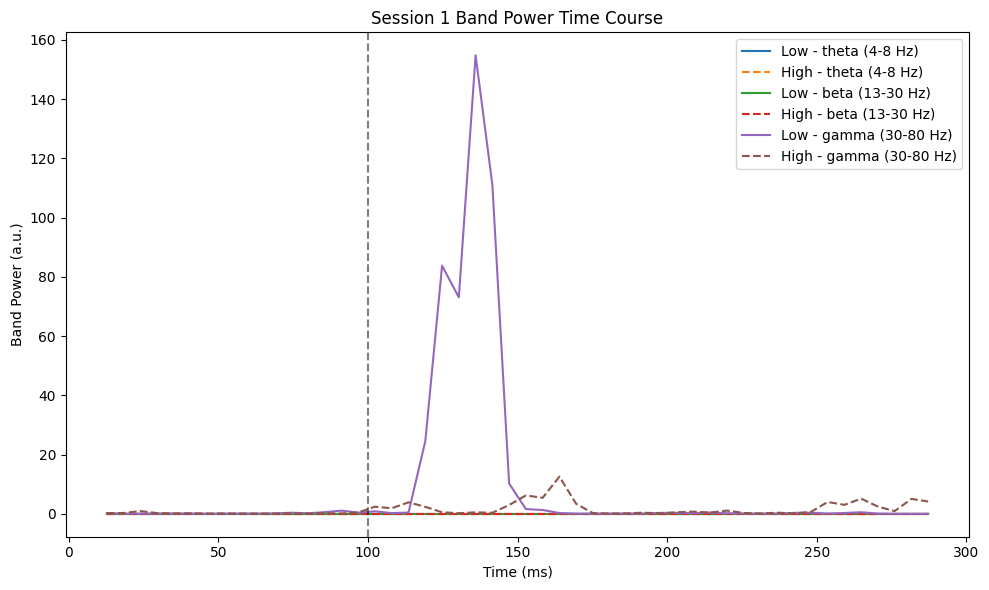

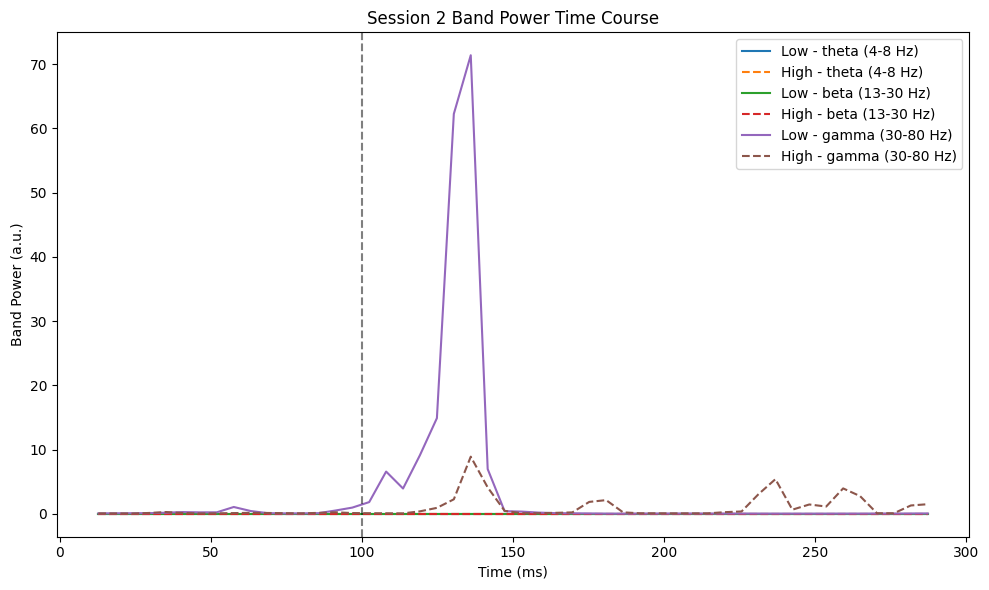

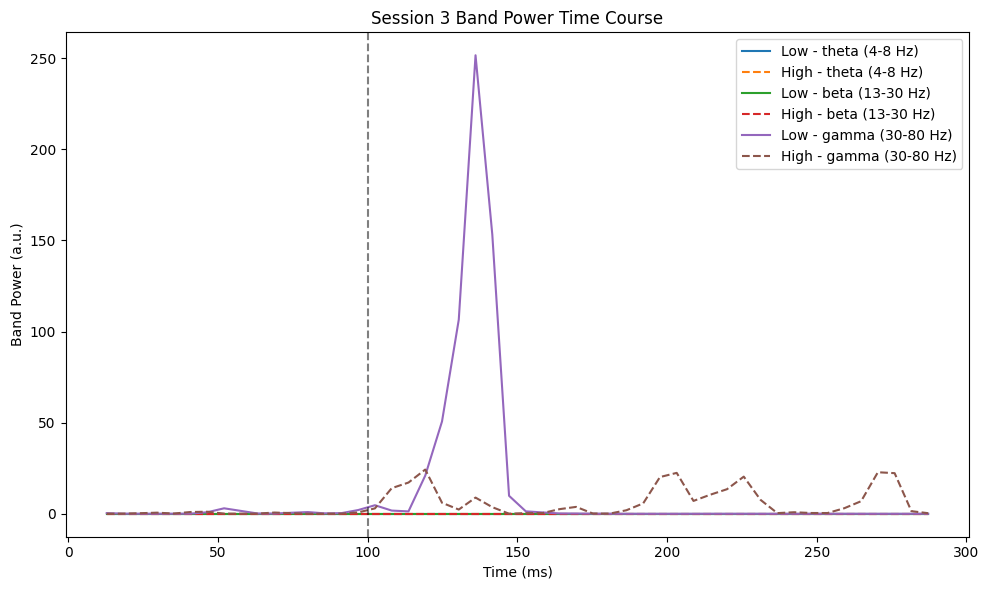

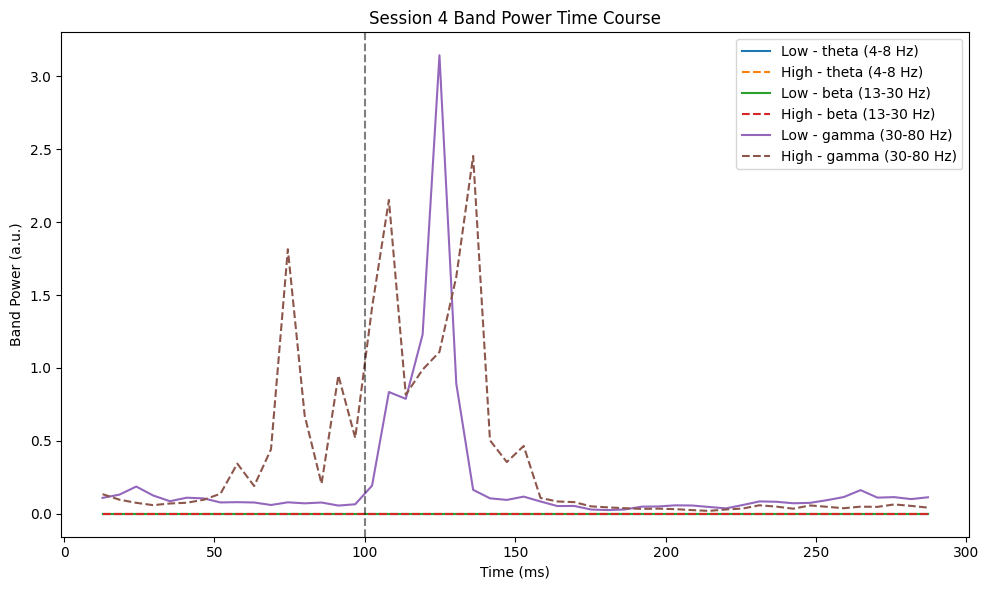

In [26]:
def extract_band_power(S, freqs, band):
    f_low, f_high = band
    mask = (freqs >= f_low) & (freqs <= f_high)
    if not np.any(mask):
        return np.zeros(S.shape[1])
    return S[mask, :].mean(axis=0)

bands = {
    "theta (4-8 Hz)"   : (4, 8),
    "beta (13-30 Hz)"  : (13, 30),
    "gamma (30-80 Hz)" : (30, 80),
}

for i in range(numSessions):
    f_l, t_l, S_l = tf_low[i]
    f_h, t_h, S_h = tf_high[i]

    plt.figure(figsize=(10, 6))
    for band_name, band_range in bands.items():
        bp_low  = extract_band_power(S_l, f_l, band_range)
        bp_high = extract_band_power(S_h, f_h, band_range)

        plt.plot(t_l * 1000.0, bp_low,  label=f"Low - {band_name}")
        plt.plot(t_h * 1000.0, bp_high, label=f"High - {band_name}", linestyle='--')

    plt.axvline(stimOnset / fs * 1000.0, color='k', linestyle='--', alpha=0.5)
    plt.title(f"Session {i+1} Band Power Time Course")
    plt.xlabel("Time (ms)")
    plt.ylabel("Band Power (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()


- Idea2 findings
    - In Sessions 1–3, a very strong increase in gamma-band (30–80 Hz) power was consistently observed in response to low-tone stimuli.
    - In Session 4, unlike other sessions, a reverse pattern was observed, with a greater increase in gamma-band power in response to high-tone stimuli.
    - These results suggest that the auditory cortex exhibits differential responses in the gamma-band depending on tone frequency.

(iii) Apply both methods to the **LFP data combined across the four sessions**, present the results in **both the time and frequency domains**, and discuss your findings, including a **comparison with the results obtained from analyzing each session separately**.


In [27]:
lfp_low_all  = np.concatenate(lfp_low_filtered, axis=0)   
lfp_high_all = np.concatenate(lfp_high_filtered, axis=0)  

- Idea1

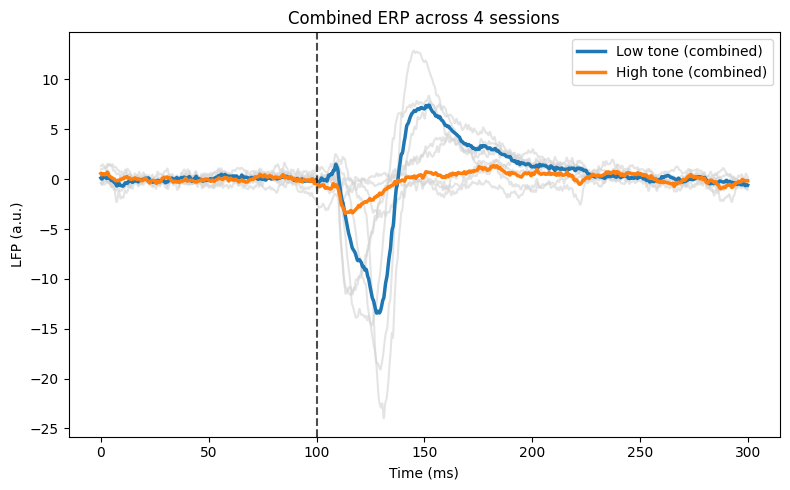

In [28]:
plt.figure(figsize=(8, 5))

# 세션별 ERP를 얇은 회색으로
for i in range(numSessions):
    plt.plot(t_ms, erp_low_all[i],  color='lightgray', alpha=0.6)
    plt.plot(t_ms, erp_high_all[i], color='lightgray', alpha=0.6)

# combined ERP를 진하게
plt.plot(t_ms, erp_low_all.mean(axis=0),  label="Low tone (combined)",  color="C0", linewidth=2.5)
plt.plot(t_ms, erp_high_all.mean(axis=0), label="High tone (combined)", color="C1", linewidth=2.5)

plt.axvline(stimOnset / fs * 1000.0, color='k', linestyle='--', alpha=0.7)
plt.xlabel("Time (ms)")
plt.ylabel("LFP (a.u.)")
plt.title("Combined ERP across 4 sessions")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
for cond_name, erp in zip(["Low", "High"], [erp_low_all[i], erp_high_all[i]]):
    start_idx = int(win_start_ms * 10); end_idx = int(win_end_ms * 10)
    segment = erp[start_idx:end_idx]
        
    local_idx = np.argmin(segment)
    peak_amp = segment[local_idx]

    peak_idx = start_idx + local_idx
    latency_ms = (peak_idx - stimOnset) / fs * 1000.0

    print(f"{cond_name} tone (combined) -> peak_amp = {peak_amp:.4f}, latency = {latency_ms:.1f} ms")

Low tone (combined) -> peak_amp = -11.6275, latency = 15.7 ms
High tone (combined) -> peak_amp = -11.5654, latency = 16.7 ms


- Idea2

In [30]:
f_low_all,  t_tf, S_low_all  = compute_mean_spectrogram(lfp_low_all,  fs)
f_high_all, t_tf, S_high_all = compute_mean_spectrogram(lfp_high_all, fs)

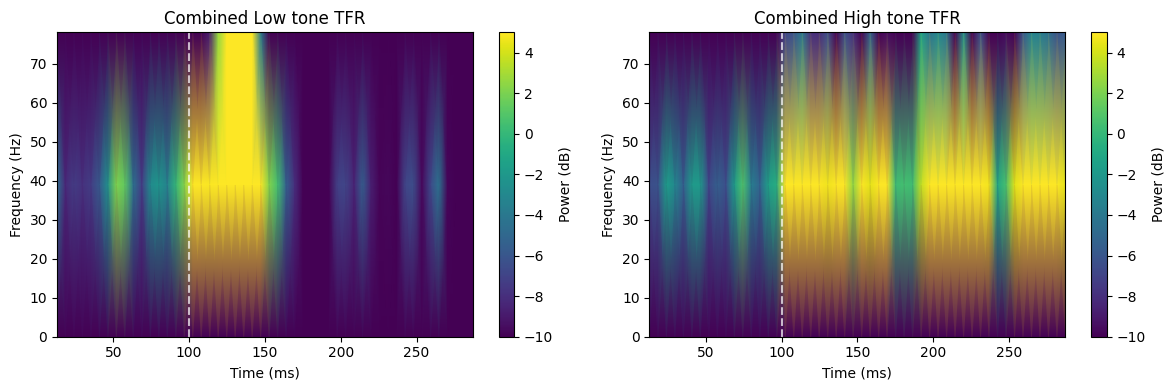

In [31]:
S_low_db  = 10 * np.log10(S_low_all  + 1e-12)
S_high_db = 10 * np.log10(S_high_all + 1e-12)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.pcolormesh(t_tf * 1000.0, f_low_all, S_low_db, shading='gouraud', vmin=vmin, vmax=vmax)
plt.axvline(stimOnset / fs * 1000.0, color='w', linestyle='--', alpha=0.7)
plt.title("Combined Low tone TFR")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power (dB)")

plt.subplot(1, 2, 2)
plt.pcolormesh(t_tf * 1000.0, f_high_all, S_high_db, shading='gouraud', vmin=vmin, vmax=vmax)
plt.axvline(stimOnset / fs * 1000.0, color='w', linestyle='--', alpha=0.7)
plt.title("Combined High tone TFR")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power (dB)")

plt.tight_layout()
plt.show()


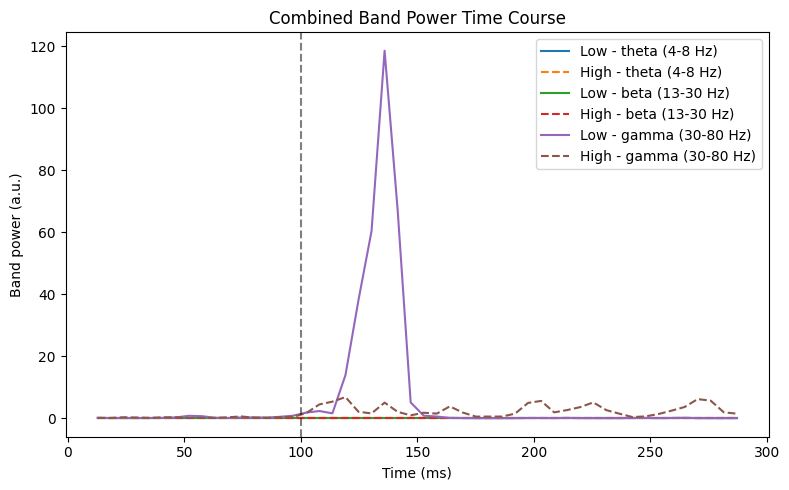

In [32]:
bands = {
    "theta (4-8 Hz)"   : (4, 8),
    "beta (13-30 Hz)"  : (13, 30),
    "gamma (30-80 Hz)" : (30, 80),
}

def extract_band_power(S, freqs, band):
    f_low, f_high = band
    mask = (freqs >= f_low) & (freqs <= f_high)
    if not np.any(mask):
        return np.zeros(S.shape[1])
    return S[mask, :].mean(axis=0)

plt.figure(figsize=(8, 5))
for band_name, band_range in bands.items():
    bp_low  = extract_band_power(S_low_all,  f_low_all,  band_range)
    bp_high = extract_band_power(S_high_all, f_high_all, band_range)
    plt.plot(t_tf * 1000.0, bp_low,  label=f"Low - {band_name}")
    plt.plot(t_tf * 1000.0, bp_high, linestyle='--', label=f"High - {band_name}")

plt.axvline(stimOnset / fs * 1000.0, color='k', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Band power (a.u.)")
plt.title("Combined Band Power Time Course")
plt.legend()
plt.tight_layout()
plt.show()


Discuss the findings 

- The differences between each session are noted in each idea section.
- Low tones (blue) show a clear negative deflection (approximately 120–140 ms) even in the average of four sessions, followed immediately by a large positive rebound. High tones (orange) show a weaker negative deflection and much smaller overall waveform fluctuations.
- The gamma increase was also evident in the session-by-session analysis, but the combined results showed noise averaged out and a much more pronounced gamma burst.
- Low tones showed a single, large gamma power peak approximately 120–140 ms after stimulation, whereas high tones showed only small, scattered gamma changes in the same period. Furthermore, no significant response was observed in the combined results for theta (4–8 Hz) and beta (13–30 Hz).

(6) **Save the Results**

* Store your outputs, including the **raw data**, **low-pass filtered data**, and **main analysis results**.

In [33]:
np.save("raw_data.npy", lfp_raw)
np.save("low_filtered_data.npy", np.array(lfp_low_filtered, dtype=object), allow_pickle=True)
np.save("high_filtered_data.npy", np.array(lfp_high_filtered, dtype=object), allow_pickle=True)

- Idea1

In [34]:
win_start_ms, win_end_ms = (100, 250)

f = open("Idea1_time_domain_results.txt", "w")
for i in range(numSessions):
    f.write(f"\n=== Session {i+1} ===\n")

    for cond_name, erp in zip(["Low", "High"], [erp_low_all[i], erp_high_all[i]]):
        start_idx = int(win_start_ms * 10); end_idx = int(win_end_ms * 10)
        segment = erp[start_idx:end_idx]
        
        local_idx = np.argmin(segment)
        peak_amp = segment[local_idx]
    
        peak_idx = start_idx + local_idx
        latency_ms = (peak_idx - stimOnset) / fs * 1000.0

        f.write(f"{cond_name} tone -> peak_amp = {peak_amp:.4f}, latency = {latency_ms:.1f} ms\n")
f.close()

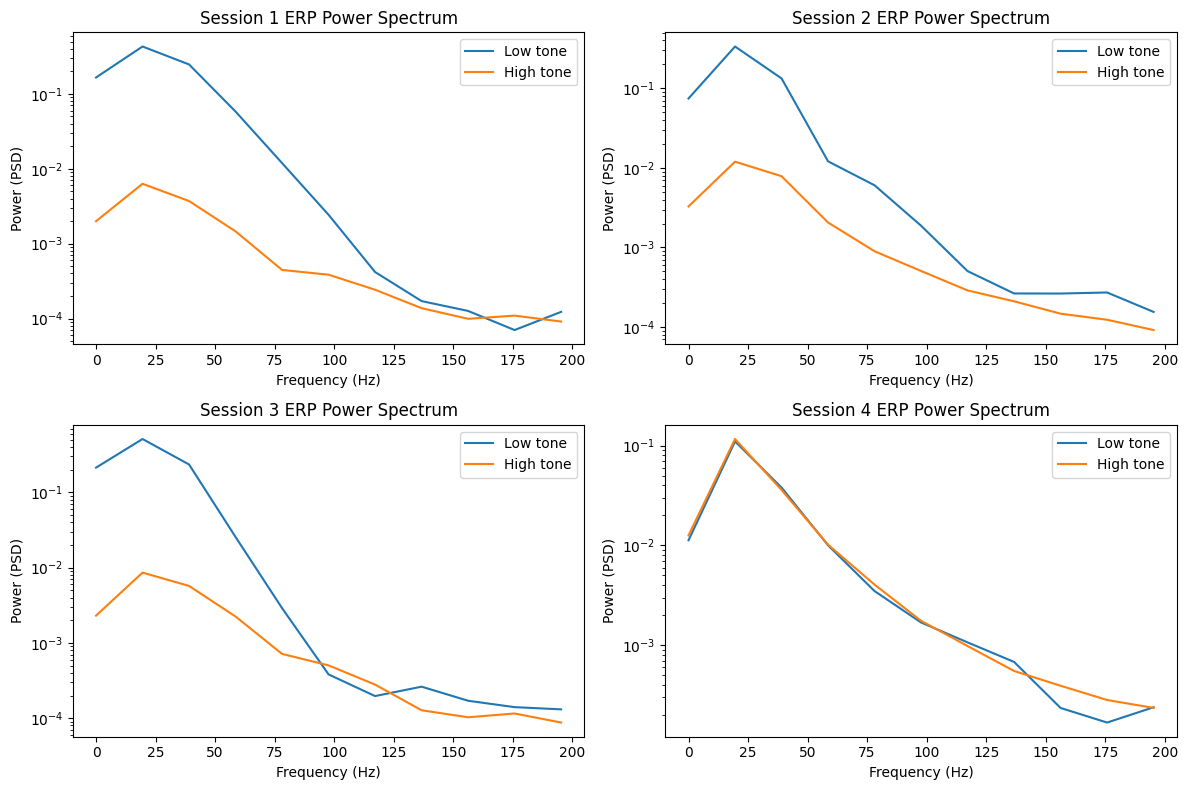

<Figure size 640x480 with 0 Axes>

In [35]:
max_freq = 200  

plt.figure(figsize=(12, 8))

for i in range(numSessions):
    erp_l = erp_low_all[i]
    erp_h = erp_high_all[i]
    
    freqs_l, psd_l = welch(erp_l, fs=fs, nperseg=512)
    freqs_h, psd_h = welch(erp_h, fs=fs, nperseg=512)
    
    mask_l = freqs_l <= max_freq
    mask_h = freqs_h <= max_freq
    
    plt.subplot(2, 2, i + 1)
    plt.semilogy(freqs_l[mask_l], psd_l[mask_l], label="Low tone")
    plt.semilogy(freqs_h[mask_h], psd_h[mask_h], label="High tone")
    
    plt.title(f"Session {i+1} ERP Power Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (PSD)")
    plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("Idea1_frequency_domain_results.png")

- Idea2

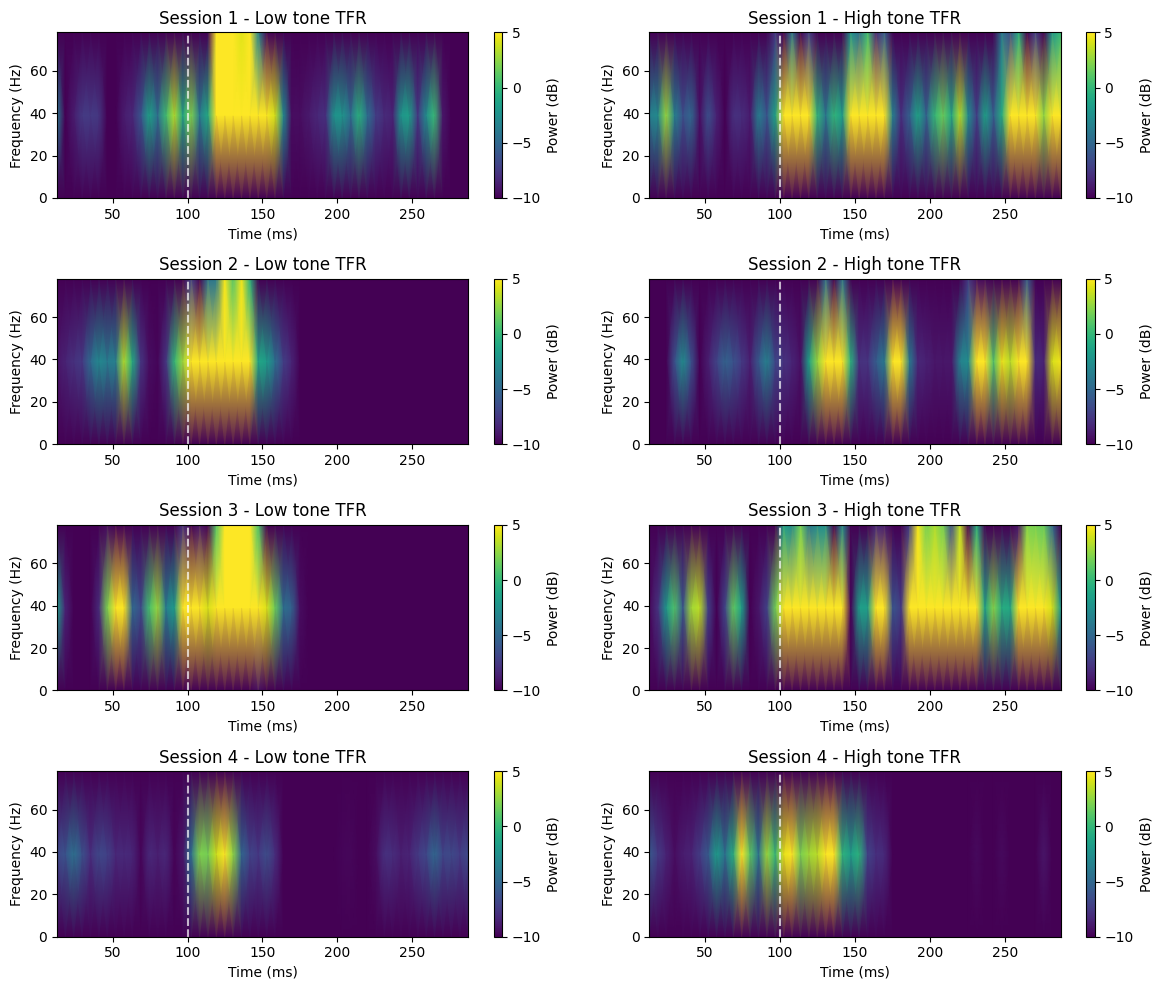

In [36]:
vmin, vmax = -10, 5
plt.figure(figsize=(12, 10))

for i in range(numSessions):
    f_l, t_l, S_l = tf_low[i]
    f_h, t_h, S_h = tf_high[i]

    S_l_db = 10 * np.log10(S_l + 1e-12)
    S_h_db = 10 * np.log10(S_h + 1e-12)

    # ---- Low tone ----
    plt.subplot(numSessions, 2, 2 * i + 1)
    plt.pcolormesh(t_l * 1000.0, f_l, S_l_db, shading='gouraud', vmin=vmin, vmax=vmax)
    plt.axvline(stimOnset / fs * 1000.0, color='w', linestyle='--', alpha=0.7)
    plt.title(f"Session {i+1} - Low tone TFR")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")

    # ---- High tone ----
    plt.subplot(numSessions, 2, 2 * i + 2)
    plt.pcolormesh(t_h * 1000.0, f_h, S_h_db, shading='gouraud', vmin=vmin, vmax=vmax)
    plt.axvline(stimOnset / fs * 1000.0, color='w', linestyle='--', alpha=0.7)
    plt.title(f"Session {i+1} - High tone TFR")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")

plt.tight_layout()
plt.savefig("Idea2_time_domain_results.png")

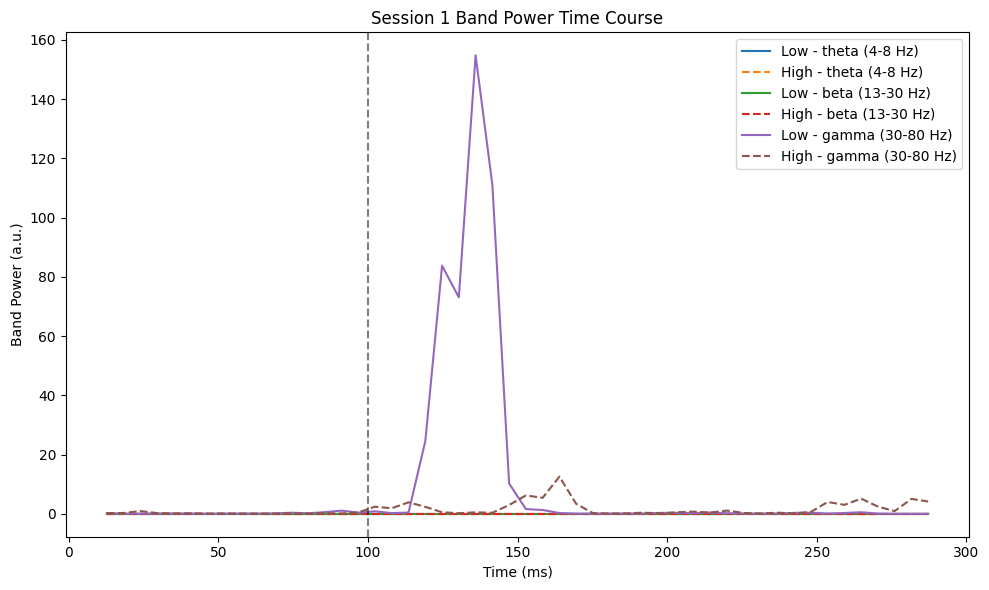

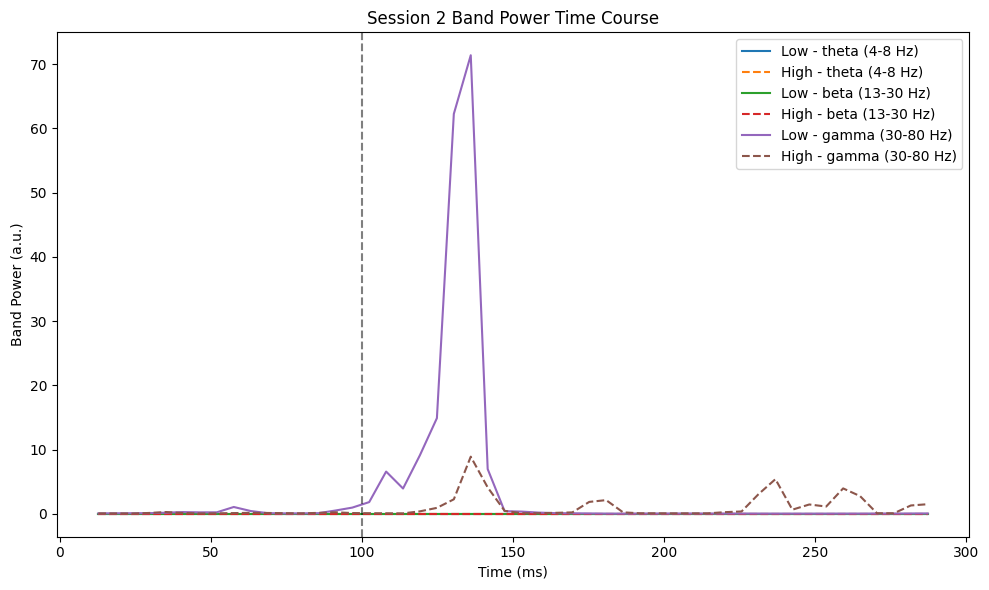

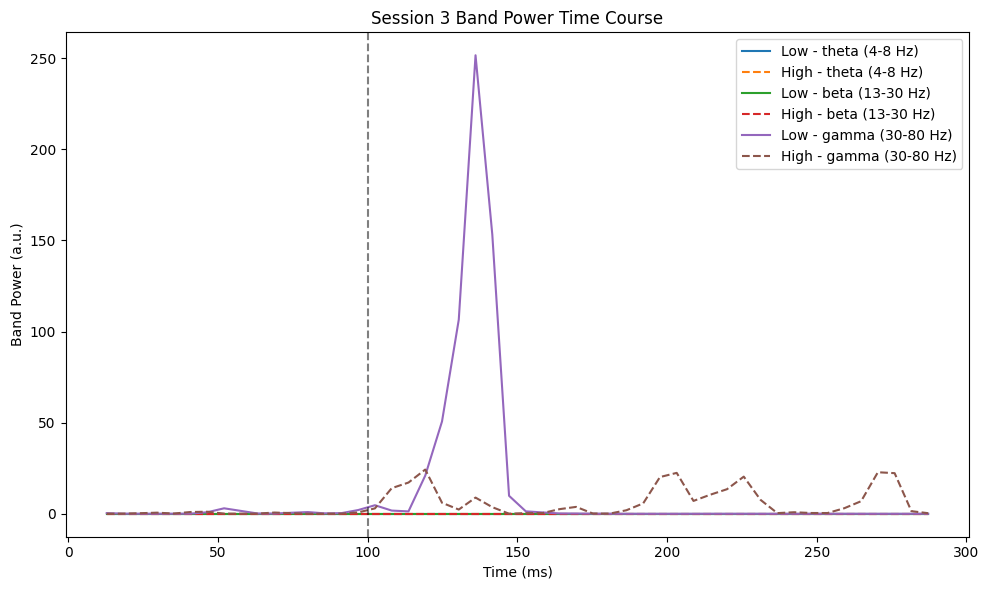

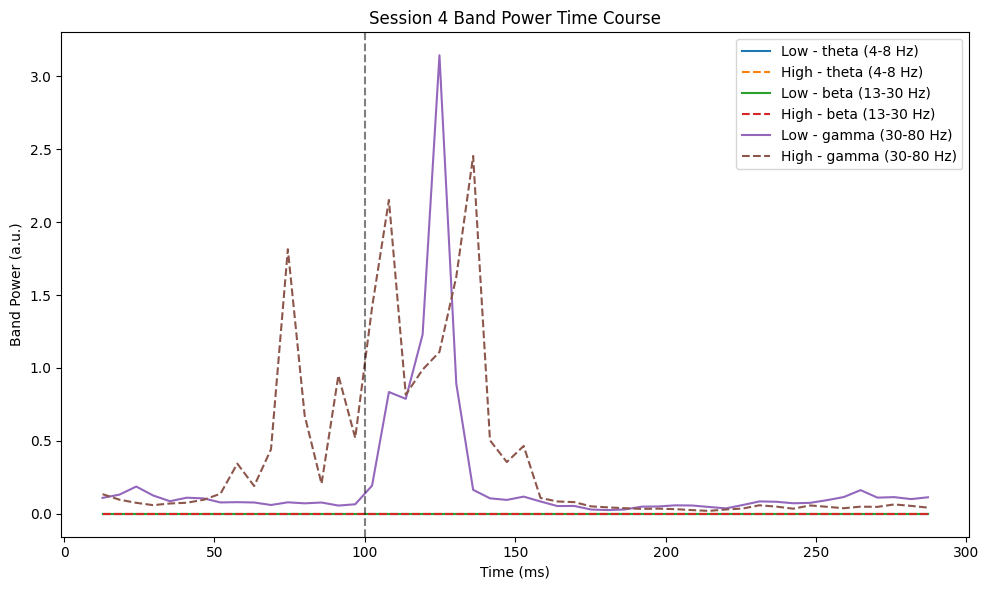

In [37]:
def extract_band_power(S, freqs, band):
    f_low, f_high = band
    mask = (freqs >= f_low) & (freqs <= f_high)
    if not np.any(mask):
        return np.zeros(S.shape[1])
    return S[mask, :].mean(axis=0)

bands = {
    "theta (4-8 Hz)"   : (4, 8),
    "beta (13-30 Hz)"  : (13, 30),
    "gamma (30-80 Hz)" : (30, 80),
}

for i in range(numSessions):
    f_l, t_l, S_l = tf_low[i]
    f_h, t_h, S_h = tf_high[i]

    plt.figure(figsize=(10, 6))
    for band_name, band_range in bands.items():
        bp_low  = extract_band_power(S_l, f_l, band_range)
        bp_high = extract_band_power(S_h, f_h, band_range)

        plt.plot(t_l * 1000.0, bp_low,  label=f"Low - {band_name}")
        plt.plot(t_h * 1000.0, bp_high, label=f"High - {band_name}", linestyle='--')

    plt.axvline(stimOnset / fs * 1000.0, color='k', linestyle='--', alpha=0.5)
    plt.title(f"Session {i+1} Band Power Time Course")
    plt.xlabel("Time (ms)")
    plt.ylabel("Band Power (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Idea2_frequency_domain_session_{i+1}_results.png")

- Session analysis

In [38]:
np.save("lfp_low_all.npy", lfp_low_all)
np.save("lfp_high_all.npy", lfp_high_all)

End of assignment